# PhysioNet EEG-ARNN Training Pipeline

This notebook implements the complete training pipeline with:
- Subject-specific 3-fold cross-validation
- Edge Selection (ES) and Aggregation Selection (AS)
- Experiments with different k values (10, 15, 20, 25)
- Comprehensive results and visualizations

## Setup and Imports

In [1]:
import sys
from pathlib import Path
import warnings
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import mne

# IMPORTANT: Force reload train_utils to get latest fixes
import importlib
import train_utils
importlib.reload(train_utils)

from models import EEGARNN, ChannelSelector
from train_utils import (
    load_preprocessed_data, filter_classes, normalize_data,
    cross_validate_subject, EEGDataset
)

warnings.filterwarnings('ignore')
mne.set_log_level('ERROR')
sns.set_context('notebook', font_scale=1.1)
plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Verify the fix is loaded
print("\n" + "="*80)
print("VERIFICATION: Checking if train_utils.py fix is loaded...")
print("="*80)
import inspect
source = inspect.getsource(load_preprocessed_data)
if 'events_from_annotations' in source:
    print("✓ GOOD: train_utils.py has the annotations fix!")
else:
    print("✗ ERROR: train_utils.py is still using old code!")
    print("  → Please restart Jupyter kernel: Kernel → Restart Kernel")
    print("  → Then re-run all cells from the top")
print("="*80)

C:\Users\SHIVAPREETHAM ROHITH\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu

VERIFICATION: Checking if train_utils.py fix is loaded...
✓ GOOD: train_utils.py has the annotations fix!


## Configuration

In [2]:
EXPERIMENT_CONFIG = {
    'data': {
        'preprocessed_dir': Path('data/physionet/derived/preprocessed'),
        'index_file': Path('data/physionet/derived/physionet_preprocessed_index.csv'),
        'selected_classes': [1, 2],  # T1, T2 (or [1, 2, 3, 4] for 4-class)
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0)
    },
    'model': {
        'hidden_dim': 40,
        'epochs': 10,  # Reduced from 100 to 50
        'learning_rate': 0.001,
        'batch_size': 32,
        'n_folds': 2
    },
    'channel_selection': {
        'k_values': [10, 15, 20, 25, 'all'],  # Different k to test
        'methods': ['ES', 'AS']  # Edge Selection, Aggregation Selection
    },
    'output': {
        'results_dir': Path('results'),
        'models_dir': Path('saved_models')
    },
    'max_subjects': 5  # Train on only 20 subjects
}

EXPERIMENT_CONFIG['output']['results_dir'].mkdir(exist_ok=True)
EXPERIMENT_CONFIG['output']['models_dir'].mkdir(exist_ok=True)

print("Experiment Configuration:")
print(json.dumps(EXPERIMENT_CONFIG, indent=2, default=str))

Experiment Configuration:
{
  "data": {
    "preprocessed_dir": "data\\physionet\\derived\\preprocessed",
    "index_file": "data\\physionet\\derived\\physionet_preprocessed_index.csv",
    "selected_classes": [
      1,
      2
    ],
    "tmin": -1.0,
    "tmax": 5.0,
    "baseline": [
      -0.5,
      0
    ]
  },
  "model": {
    "hidden_dim": 40,
    "epochs": 10,
    "learning_rate": 0.001,
    "batch_size": 32,
    "n_folds": 2
  },
  "channel_selection": {
    "k_values": [
      10,
      15,
      20,
      25,
      "all"
    ],
    "methods": [
      "ES",
      "AS"
    ]
  },
  "output": {
    "results_dir": "results",
    "models_dir": "saved_models"
  },
  "max_subjects": 5
}


## Load Preprocessed Data Index

In [3]:
index_df = pd.read_csv(EXPERIMENT_CONFIG['data']['index_file'])
success_df = index_df[index_df['status'] == 'success'].copy()

print(f"Total preprocessed runs: {len(index_df)}")
print(f"Successful runs: {len(success_df)}")
print(f"\nSubjects available: {success_df['subject'].nunique()}")
print(f"\nRuns per category:")
print(success_df.groupby('category')['run'].count())

success_df.head()

Total preprocessed runs: 669
Successful runs: 669

Subjects available: 51

Runs per category:
category
motor_execution    292
motor_imagery      295
resting_state       82
Name: run, dtype: int64


,subject,run,status,path,timestamp,original_sfreq,n_channels_original,duration_s,bad_channels,n_bad_channels,notch_applied,final_sfreq,n_channels_final,file_size_mb,category,task,bad_channels_interpolated
0,S001,R01,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-23T17:52:38.863386,160.0,64,60.99375,[],0,[50.0],128.0,64,1.917076,resting_state,Baseline eyes open,NaN
1,S001,R02,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-23T17:52:39.482853,160.0,64,60.99375,[],0,[50.0],128.0,64,1.917076,resting_state,Baseline eyes closed,NaN
2,S001,R04,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-23T17:52:39.869856,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close right fist (executed),NaN
3,S001,R05,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-23T17:52:40.658595,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close both fists (executed),NaN
4,S001,R06,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-23T17:52:41.551311,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close both feet (executed),NaN


## Subject Selection

Select subjects for training. For motor imagery, we focus on motor execution and motor imagery runs.

In [4]:
# Filter motor-related runs (execution and imagery)
motor_runs = success_df[success_df['category'].isin(['motor_execution', 'motor_imagery'])].copy()

# Count runs per subject
subject_counts = motor_runs.groupby('subject').size().reset_index(name='num_runs')
subject_counts = subject_counts[subject_counts['num_runs'] >= 10]  # At least 10 runs

selected_subjects = subject_counts['subject'].tolist()

print(f"Subjects with >=10 motor runs: {len(selected_subjects)}")
print(f"\nFirst 10 subjects: {selected_subjects[:10]}")

# Limit to max_subjects for this experiment
max_subjects = EXPERIMENT_CONFIG.get('max_subjects', len(selected_subjects))
selected_subjects = selected_subjects[:max_subjects]

print(f"\nWill train on {len(selected_subjects)} subjects")
print(f"Selected subjects: {selected_subjects}")

Subjects with >=10 motor runs: 49

First 10 subjects: ['S001', 'S002', 'S005', 'S006', 'S007', 'S008', 'S011', 'S014', 'S015', 'S016']

Will train on 5 subjects
Selected subjects: ['S001', 'S002', 'S005', 'S006', 'S007']


## Helper Functions

In [5]:
def load_subject_data(subject_id, preprocessed_dir, motor_runs_df, config):
    """
    Load all motor runs for a subject and concatenate
    
    Returns
    -------
    data : np.ndarray or None
        (n_trials, n_channels, n_timepoints)
    labels : np.ndarray or None
        (n_trials,)
    channel_names : list
        List of channel names
    """
    subject_runs = motor_runs_df[motor_runs_df['subject'] == subject_id]
    
    all_data = []
    all_labels = []
    channel_names = None
    
    for _, run_info in subject_runs.iterrows():
        fif_path = Path(run_info['path'])
        
        if not fif_path.exists():
            continue
        
        try:
            data, labels = load_preprocessed_data(
                fif_path,
                tmin=config['data']['tmin'],
                tmax=config['data']['tmax'],
                baseline=config['data']['baseline']
            )
            
            if data is not None and len(data) > 0:
                all_data.append(data)
                all_labels.append(labels)
                
                if channel_names is None:
                    raw = mne.io.read_raw_fif(fif_path, preload=False, verbose='ERROR')
                    channel_names = raw.ch_names
                    
        except Exception as e:
            print(f"Error loading {fif_path.name}: {e}")
            continue
    
    if len(all_data) == 0:
        return None, None, None
    
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # Filter to selected classes
    all_data, all_labels = filter_classes(
        all_data, all_labels, config['data']['selected_classes']
    )
    
    return all_data, all_labels, channel_names

## Main Training Loop

Train subject-specific models with 3-fold cross-validation

In [6]:
all_results = []

for subject_id in tqdm(selected_subjects, desc="Training subjects"):
    print(f"\n{'='*80}")
    print(f"Training subject: {subject_id}")
    print(f"{'='*80}")
    
    # Load subject data
    data, labels, channel_names = load_subject_data(
        subject_id, 
        EXPERIMENT_CONFIG['data']['preprocessed_dir'],
        motor_runs,
        EXPERIMENT_CONFIG
    )
    
    if data is None or len(data) < 30:  # Need at least 30 trials for 3-fold CV
        print(f"Skipping {subject_id}: insufficient data")
        continue
    
    print(f"Data shape: {data.shape}")
    print(f"Labels: {np.unique(labels, return_counts=True)}")
    print(f"Channels: {len(channel_names)}")
    
    num_channels = data.shape[1]
    num_timepoints = data.shape[2]
    num_classes = len(np.unique(labels))
    
    # Perform 3-fold cross-validation
    cv_results = cross_validate_subject(
        data, labels,
        num_channels=num_channels,
        num_timepoints=num_timepoints,
        num_classes=num_classes,
        device=device,
        n_splits=EXPERIMENT_CONFIG['model']['n_folds'],
        epochs=EXPERIMENT_CONFIG['model']['epochs'],
        lr=EXPERIMENT_CONFIG['model']['learning_rate']
    )
    
    print(f"\nAverage accuracy (all channels): {cv_results['avg_accuracy']:.4f} ± {cv_results['std_accuracy']:.4f}")
    
    # Save results
    result = {
        'subject': subject_id,
        'num_trials': len(data),
        'num_channels': num_channels,
        'num_timepoints': num_timepoints,
        'num_classes': num_classes,
        'all_channels_acc': cv_results['avg_accuracy'],
        'all_channels_std': cv_results['std_accuracy'],
        'adjacency_matrix': cv_results['adjacency_matrix'],
        'channel_names': channel_names
    }
    
    all_results.append(result)

print(f"\n{'='*80}")
print(f"Training complete for {len(all_results)} subjects")
print(f"{'='*80}")

Training subjects:   0%|          | 0/5 [00:00<?, ?it/s]


Training subject: S001
Data shape: (231, 64, 769)
Labels: (array([0, 1]), array([154,  77], dtype=int64))
Channels: 64
  Fold 1/2 -> Acc: 0.595 (stopped at epoch 10)
  Fold 2/2 

Training subjects:  20%|██        | 1/5 [28:01<1:52:05, 1681.37s/it]

-> Acc: 0.774 (stopped at epoch 10)

Average accuracy (all channels): 0.6844 ± 0.0895

Training subject: S002
Data shape: (231, 64, 769)
Labels: (array([0, 1]), array([154,  77], dtype=int64))
Channels: 64
  Fold 1/2 -> Acc: 0.724 (stopped at epoch 10)
  Fold 2/2 

Training subjects:  40%|████      | 2/5 [54:49<1:21:54, 1638.14s/it]

-> Acc: 0.661 (stopped at epoch 10)

Average accuracy (all channels): 0.6925 ± 0.0316

Training subject: S005
Data shape: (252, 64, 769)
Labels: (array([0, 1]), array([168,  84], dtype=int64))
Channels: 64
  Fold 1/2 -> Acc: 0.627 (stopped at epoch 10)
  Fold 2/2 

Training subjects:  60%|██████    | 3/5 [1:22:22<54:50, 1645.21s/it]

-> Acc: 0.675 (stopped at epoch 9)

Average accuracy (all channels): 0.6508 ± 0.0238

Training subject: S006
Data shape: (252, 64, 769)
Labels: (array([0, 1]), array([168,  84], dtype=int64))
Channels: 64
  Fold 1/2 -> Acc: 0.714 (stopped at epoch 10)
  Fold 2/2 

Training subjects:  80%|████████  | 4/5 [1:50:48<27:49, 1669.16s/it]

-> Acc: 0.667 (stopped at epoch 10)

Average accuracy (all channels): 0.6905 ± 0.0238

Training subject: S007
Data shape: (252, 64, 769)
Labels: (array([0, 1]), array([168,  84], dtype=int64))
Channels: 64
  Fold 1/2 -> Acc: 0.913 (stopped at epoch 10)
  Fold 2/2 

Training subjects: 100%|██████████| 5/5 [2:19:18<00:00, 1671.73s/it]

-> Acc: 0.913 (stopped at epoch 10)

Average accuracy (all channels): 0.9127 ± 0.0000

Training complete for 5 subjects


## Channel Selection Experiments

Test different k values with Edge Selection and Aggregation Selection

In [7]:
channel_selection_results = []

if len(all_results) > 0:
    for result in tqdm(all_results, desc="Channel selection experiments"):
        subject_id = result['subject']
        adj_matrix = result['adjacency_matrix']
        channel_names = result['channel_names']
        
        print(f"\nProcessing channel selection for {subject_id}")
        
        selector = ChannelSelector(adj_matrix, channel_names)
        
        for method in EXPERIMENT_CONFIG['channel_selection']['methods']:
            print(f"  Method: {method}")
            
            for k in EXPERIMENT_CONFIG['channel_selection']['k_values']:
                if k == 'all':
                    k_val = result['num_channels']
                    selected_channels = channel_names
                else:
                    k_val = min(k, result['num_channels'])  # Don't exceed available channels
                    
                    if method == 'ES':
                        selected_channels, _ = selector.edge_selection(k_val)
                    else:  # AS
                        selected_channels, _ = selector.aggregation_selection(k_val)
                
                print(f"    k={k_val}: {len(selected_channels)} channels selected")
                
                channel_selection_results.append({
                    'subject': subject_id,
                    'method': method,
                    'k': k_val,
                    'num_selected': len(selected_channels),
                    'selected_channels': selected_channels,
                    'accuracy_full': result['all_channels_acc']
                })

    channel_selection_df = pd.DataFrame(channel_selection_results)
    print(f"\nChannel selection results: {len(channel_selection_df)} experiments")
    display(channel_selection_df.head(10))
else:
    channel_selection_df = pd.DataFrame()
    print("\nNo results available for channel selection experiments.")

Channel selection experiments: 100%|██████████| 5/5 [00:00<00:00, 72.44it/s]


Processing channel selection for S001
  Method: ES
    k=10: 18 channels selected
    k=15: 25 channels selected
    k=20: 31 channels selected
    k=25: 36 channels selected
    k=64: 64 channels selected
  Method: AS
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected

Processing channel selection for S002
  Method: ES
    k=10: 18 channels selected
    k=15: 27 channels selected
    k=20: 32 channels selected
    k=25: 35 channels selected
    k=64: 64 channels selected
  Method: AS
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected

Processing channel selection for S005
  Method: ES
    k=10: 18 channels selected
    k=15: 25 channels selected
    k=20: 30 channels selected
    k=25: 34 channels selected
    k=64: 64 channels selected
  Method: AS
    k=10: 10 channels selected

,subject,method,k,num_selected,selected_channels,accuracy_full
0,S001,ES,10,18,"[Fc1, Fcz, Fc2, C2, Cp5, Cp1, Cpz, Fp2, Af7, A...",0.68437
1,S001,ES,15,25,"[Fc1, Fcz, Fc2, Fc4, Fc6, C2, C4, Cp5, Cp1, Cp...",0.68437
2,S001,ES,20,31,"[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C2, C4, Cp...",0.68437
3,S001,ES,25,36,"[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C2, C4...",0.68437
4,S001,ES,64,64,"[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...",0.68437
5,S001,AS,10,10,"[C5, C1, Af7, Af8, F5, F2, Ft7, Ft8, T9, O1]",0.68437
6,S001,AS,15,15,"[Fc3, Fc1, C5, C1, C2, Cpz, Af7, Af8, F5, F2, ...",0.68437
7,S001,AS,20,20,"[Fc3, Fc1, C5, C1, C2, Cp3, Cpz, Cp6, Af7, Af8...",0.68437
8,S001,AS,25,25,"[Fc3, Fc1, Fcz, C5, C1, C2, Cp3, Cpz, Cp2, Cp6...",0.68437
9,S001,AS,64,64,"[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...",0.68437


In [8]:
from train_utils import retrain_with_selected_channels

# Store all retraining results
retrain_results = []

if len(all_results) > 0:
    # We need the original data for each subject  
    # Load subject data cache
    subject_data_cache = {}
    
    for result in all_results:
        subject_id = result['subject']
        print(f"\nLoading data for {subject_id}")
        
        # Load subject data
        data, labels, channel_names = load_subject_data(
            subject_id, 
            EXPERIMENT_CONFIG['data']['preprocessed_dir'],
            motor_runs,
            EXPERIMENT_CONFIG
        )
        
        if data is None:
            continue
            
        subject_data_cache[subject_id] = {
            'data': data,
            'labels': labels,
            'channel_names': channel_names
        }
    
    print(f"\n{'='*80}")
    print("RETRAINING WITH SELECTED CHANNELS")
    print(f"{'='*80}\n")
    
    for result in tqdm(all_results, desc="Retraining subjects"):
        subject_id = result['subject']
        
        if subject_id not in subject_data_cache:
            continue
            
        cache = subject_data_cache[subject_id]
        data = cache['data']
        labels = cache['labels']
        channel_names = cache['channel_names']
        
        print(f"\nRetraining {subject_id}")
        
        selector = ChannelSelector(result['adjacency_matrix'], channel_names)
        
        # Test each k value for both methods
        for method in EXPERIMENT_CONFIG['channel_selection']['methods']:
            for k in EXPERIMENT_CONFIG['channel_selection']['k_values']:
                if k == 'all':
                    continue  # Skip, already have full results
                
                k_val = min(k, result['num_channels'])
                
                # Get selected channels
                if method == 'ES':
                    selected_channels, selected_indices = selector.edge_selection(k_val)
                else:  # AS
                    selected_channels, selected_indices = selector.aggregation_selection(k_val)
                
                print(f"  {method} k={k_val}: Retraining with {len(selected_channels)} channels...")
                
                # Retrain with selected channels
                retrain_res = retrain_with_selected_channels(
                    data, labels,
                    selected_channel_indices=selected_indices,
                    num_timepoints=result['num_timepoints'],
                    num_classes=result['num_classes'],
                    device=device,
                    n_splits=EXPERIMENT_CONFIG['model']['n_folds'],
                    epochs=EXPERIMENT_CONFIG['model']['epochs'],
                    lr=EXPERIMENT_CONFIG['model']['learning_rate']
                )
                
                acc_drop = result['all_channels_acc'] - retrain_res['avg_accuracy']
                
                print(f"    Accuracy: {retrain_res['avg_accuracy']:.4f} ± {retrain_res['std_accuracy']:.4f}")
                print(f"    Drop from full: {acc_drop:.4f} ({acc_drop/result['all_channels_acc']*100:.1f}%)")
                
                retrain_results.append({
                    'subject': subject_id,
                    'method': method,
                    'k': k_val,
                    'num_channels_selected': len(selected_channels),
                    'selected_channels': selected_channels,
                    'accuracy': retrain_res['avg_accuracy'],
                    'std': retrain_res['std_accuracy'],
                    'full_channels_acc': result['all_channels_acc'],
                    'accuracy_drop': acc_drop,
                    'accuracy_drop_pct': acc_drop / result['all_channels_acc'] * 100
                })
    
    retrain_df = pd.DataFrame(retrain_results)
    print(f"\n{'='*80}")
    print(f"Retraining complete: {len(retrain_df)} experiments")
    print(f"{'='*80}\n")
    
    # Save retrain results
    retrain_path = EXPERIMENT_CONFIG['output']['results_dir'] / 'retrain_results.csv'
    retrain_df.to_csv(retrain_path, index=False)
    print(f"Retrain results saved to: {retrain_path}")
else:
    retrain_df = pd.DataFrame()
    print("No results to retrain. Please run training first.")


Loading data for S001

Loading data for S002

Loading data for S005

Loading data for S006

Loading data for S007

RETRAINING WITH SELECTED CHANNELS



Retraining subjects:   0%|          | 0/5 [00:00<?, ?it/s]


Retraining S001
  ES k=10: Retraining with 18 channels...
    Accuracy: 0.4719 ± 0.0150
    Drop from full: 0.2124 (31.0%)
  ES k=15: Retraining with 25 channels...
    Accuracy: 0.5322 ± 0.0540
    Drop from full: 0.1521 (22.2%)
  ES k=20: Retraining with 31 channels...
    Accuracy: 0.6322 ± 0.0374
    Drop from full: 0.0522 (7.6%)
  ES k=25: Retraining with 36 channels...
    Accuracy: 0.6970 ± 0.0013
    Drop from full: -0.0126 (-1.8%)
  AS k=10: Retraining with 10 channels...
    Accuracy: 0.6060 ± 0.0147
    Drop from full: 0.0784 (11.5%)
  AS k=15: Retraining with 15 channels...
    Accuracy: 0.5104 ± 0.1017
    Drop from full: 0.1740 (25.4%)
  AS k=20: Retraining with 20 channels...
    Accuracy: 0.5621 ± 0.1534
    Drop from full: 0.1223 (17.9%)
  AS k=25: Retraining with 25 channels...


Retraining subjects:  20%|██        | 1/5 [59:34<3:58:17, 3574.41s/it]

    Accuracy: 0.5795 ± 0.1274
    Drop from full: 0.1048 (15.3%)

Retraining S002
  ES k=10: Retraining with 18 channels...
    Accuracy: 0.6320 ± 0.0027
    Drop from full: 0.0605 (8.7%)
  ES k=15: Retraining with 27 channels...
    Accuracy: 0.6492 ± 0.0318
    Drop from full: 0.0433 (6.3%)
  ES k=20: Retraining with 32 channels...
    Accuracy: 0.6018 ± 0.0243
    Drop from full: 0.0907 (13.1%)
  ES k=25: Retraining with 35 channels...
    Accuracy: 0.6796 ± 0.0014
    Drop from full: 0.0129 (1.9%)
  AS k=10: Retraining with 10 channels...
    Accuracy: 0.6666 ± 0.0231
    Drop from full: 0.0259 (3.7%)
  AS k=15: Retraining with 15 channels...
    Accuracy: 0.5365 ± 0.0583
    Drop from full: 0.1560 (22.5%)
  AS k=20: Retraining with 20 channels...
    Accuracy: 0.6709 ± 0.0187
    Drop from full: 0.0216 (3.1%)
  AS k=25: Retraining with 25 channels...


Retraining subjects:  40%|████      | 2/5 [2:05:46<3:10:24, 3808.08s/it]

    Accuracy: 0.6971 ± 0.0333
    Drop from full: -0.0046 (-0.7%)

Retraining S005
  ES k=10: Retraining with 18 channels...
    Accuracy: 0.5238 ± 0.1905
    Drop from full: 0.1270 (19.5%)
  ES k=15: Retraining with 25 channels...
    Accuracy: 0.5357 ± 0.1944
    Drop from full: 0.1151 (17.7%)
  ES k=20: Retraining with 30 channels...
    Accuracy: 0.7341 ± 0.0516
    Drop from full: -0.0833 (-12.8%)
  ES k=25: Retraining with 34 channels...
    Accuracy: 0.5873 ± 0.1429
    Drop from full: 0.0635 (9.8%)
  AS k=10: Retraining with 10 channels...
    Accuracy: 0.4167 ± 0.0119
    Drop from full: 0.2341 (36.0%)
  AS k=15: Retraining with 15 channels...
    Accuracy: 0.7183 ± 0.0278
    Drop from full: -0.0675 (-10.4%)
  AS k=20: Retraining with 20 channels...
    Accuracy: 0.5317 ± 0.1111
    Drop from full: 0.1190 (18.3%)
  AS k=25: Retraining with 25 channels...


Retraining subjects:  60%|██████    | 3/5 [3:13:51<2:11:09, 3934.72s/it]

    Accuracy: 0.6230 ± 0.0040
    Drop from full: 0.0278 (4.3%)

Retraining S006
  ES k=10: Retraining with 19 channels...
    Accuracy: 0.4960 ± 0.0516
    Drop from full: 0.1944 (28.2%)
  ES k=15: Retraining with 23 channels...
    Accuracy: 0.4960 ± 0.0119
    Drop from full: 0.1944 (28.2%)
  ES k=20: Retraining with 30 channels...
    Accuracy: 0.6905 ± 0.0079
    Drop from full: 0.0000 (0.0%)
  ES k=25: Retraining with 33 channels...
    Accuracy: 0.5556 ± 0.0079
    Drop from full: 0.1349 (19.5%)
  AS k=10: Retraining with 10 channels...
    Accuracy: 0.6508 ± 0.1111
    Drop from full: 0.0397 (5.7%)
  AS k=15: Retraining with 15 channels...
    Accuracy: 0.7262 ± 0.0992
    Drop from full: -0.0357 (-5.2%)
  AS k=20: Retraining with 20 channels...
    Accuracy: 0.6468 ± 0.0913
    Drop from full: 0.0437 (6.3%)
  AS k=25: Retraining with 25 channels...


Retraining subjects:  80%|████████  | 4/5 [4:24:32<1:07:35, 4055.73s/it]

    Accuracy: 0.5317 ± 0.1270
    Drop from full: 0.1587 (23.0%)

Retraining S007
  ES k=10: Retraining with 17 channels...
    Accuracy: 0.8770 ± 0.0119
    Drop from full: 0.0357 (3.9%)
  ES k=15: Retraining with 22 channels...
    Accuracy: 0.8690 ± 0.0357
    Drop from full: 0.0437 (4.8%)
  ES k=20: Retraining with 31 channels...
    Accuracy: 0.8611 ± 0.0040
    Drop from full: 0.0516 (5.7%)
  ES k=25: Retraining with 35 channels...
    Accuracy: 0.8254 ± 0.0079
    Drop from full: 0.0873 (9.6%)
  AS k=10: Retraining with 10 channels...
    Accuracy: 0.8214 ± 0.0357
    Drop from full: 0.0913 (10.0%)
  AS k=15: Retraining with 15 channels...
    Accuracy: 0.8968 ± 0.0079
    Drop from full: 0.0159 (1.7%)
  AS k=20: Retraining with 20 channels...
    Accuracy: 0.8175 ± 0.0714
    Drop from full: 0.0952 (10.4%)
  AS k=25: Retraining with 25 channels...


Retraining subjects: 100%|██████████| 5/5 [5:32:24<00:00, 3988.91s/it]  

    Accuracy: 0.7183 ± 0.1627
    Drop from full: 0.1944 (21.3%)

Retraining complete: 40 experiments

Retrain results saved to: results\retrain_results.csv


## Retrain with Selected Channels

Now retrain the model using ONLY the selected channels and compare accuracy

## Results Summary

In [9]:
results_df = pd.DataFrame(all_results)

print("=" * 80)
print("OVERALL RESULTS SUMMARY")
print("=" * 80)
print(f"\nSubjects trained: {len(results_df)}")

if len(results_df) > 0:
    print(f"Mean accuracy (all channels): {results_df['all_channels_acc'].mean():.4f} ± {results_df['all_channels_acc'].std():.4f}")
    print(f"Best subject: {results_df.loc[results_df['all_channels_acc'].idxmax(), 'subject']} ({results_df['all_channels_acc'].max():.4f})")
    print(f"Worst subject: {results_df.loc[results_df['all_channels_acc'].idxmin(), 'subject']} ({results_df['all_channels_acc'].min():.4f})")

    # Save results
    results_path = EXPERIMENT_CONFIG['output']['results_dir'] / 'subject_results.csv'
    results_df[['subject', 'num_trials', 'num_channels', 'all_channels_acc', 'all_channels_std']].to_csv(results_path, index=False)
    print(f"\nResults saved to: {results_path}")

    display(results_df[['subject', 'num_trials', 'num_channels', 'all_channels_acc', 'all_channels_std']].head(10))
else:
    print("\nNo subjects were successfully trained. Check the data loading and preprocessing steps.")
    results_df

OVERALL RESULTS SUMMARY

Subjects trained: 5
Mean accuracy (all channels): 0.7262 ± 0.1056
Best subject: S007 (0.9127)
Worst subject: S005 (0.6508)

Results saved to: results\subject_results.csv


,subject,num_trials,num_channels,all_channels_acc,all_channels_std
0,S001,231,64,0.684370,0.089543
1,S002,231,64,0.692504,0.031634
2,S005,252,64,0.650794,0.023810
3,S006,252,64,0.690476,0.023810
4,S007,252,64,0.912698,0.000000


## Visualizations

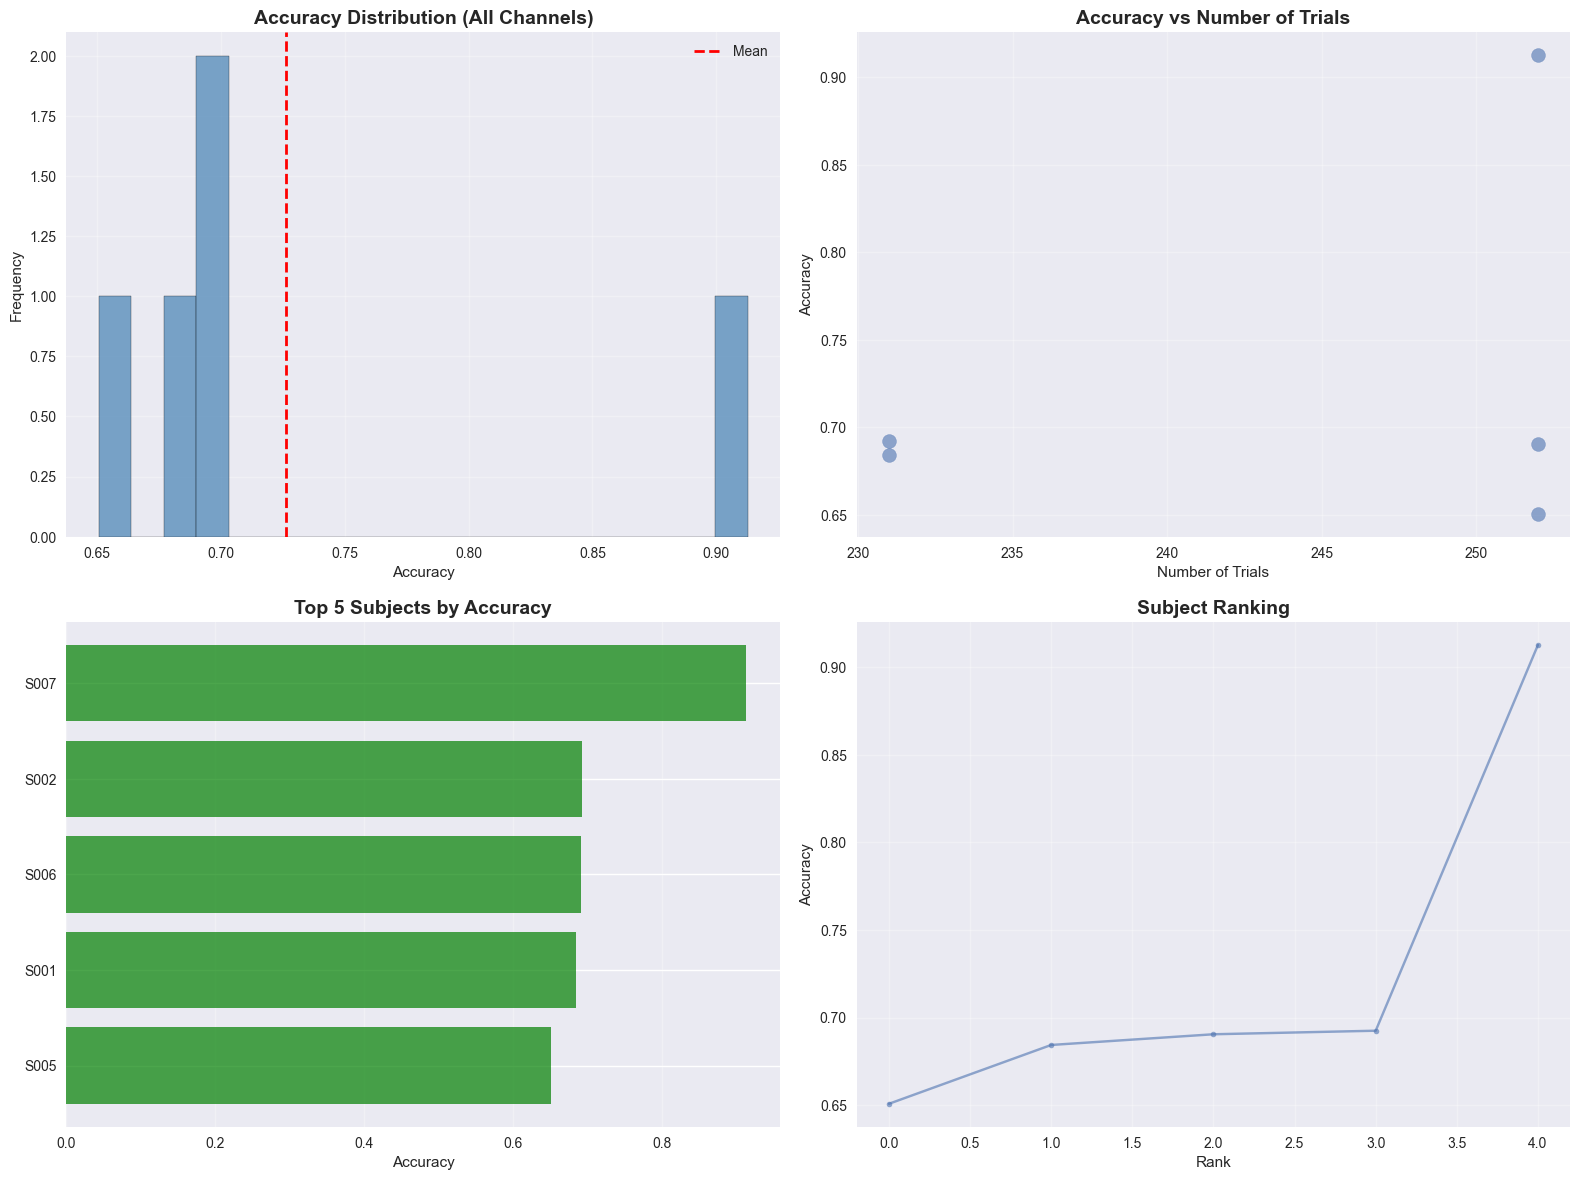

Visualizations saved to: results


In [10]:
if len(results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Accuracy distribution
    axes[0, 0].hist(results_df['all_channels_acc'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(results_df['all_channels_acc'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    axes[0, 0].set_title('Accuracy Distribution (All Channels)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Accuracy')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy vs num trials
    axes[0, 1].scatter(results_df['num_trials'], results_df['all_channels_acc'], alpha=0.6, s=100)
    axes[0, 1].set_title('Accuracy vs Number of Trials', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Number of Trials')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].grid(True, alpha=0.3)

    # Top 10 subjects
    top_10 = results_df.nlargest(min(10, len(results_df)), 'all_channels_acc')
    axes[1, 0].barh(range(len(top_10)), top_10['all_channels_acc'], color='green', alpha=0.7)
    axes[1, 0].set_yticks(range(len(top_10)))
    axes[1, 0].set_yticklabels(top_10['subject'])
    axes[1, 0].set_title(f'Top {len(top_10)} Subjects by Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Accuracy')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(True, alpha=0.3, axis='x')

    # Subject ranking
    sorted_results = results_df.sort_values('all_channels_acc')
    axes[1, 1].plot(range(len(sorted_results)), sorted_results['all_channels_acc'], marker='o', markersize=4, alpha=0.6)
    axes[1, 1].set_title('Subject Ranking', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Rank')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(EXPERIMENT_CONFIG['output']['results_dir'] / 'results_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Visualizations saved to: {EXPERIMENT_CONFIG['output']['results_dir']}")
else:
    print("No results to visualize. Please ensure subjects were successfully trained.")

## Visualize Learned Adjacency Matrix (Example Subject)

Visualizing adjacency matrix for best subject: S007
Accuracy: 0.9127


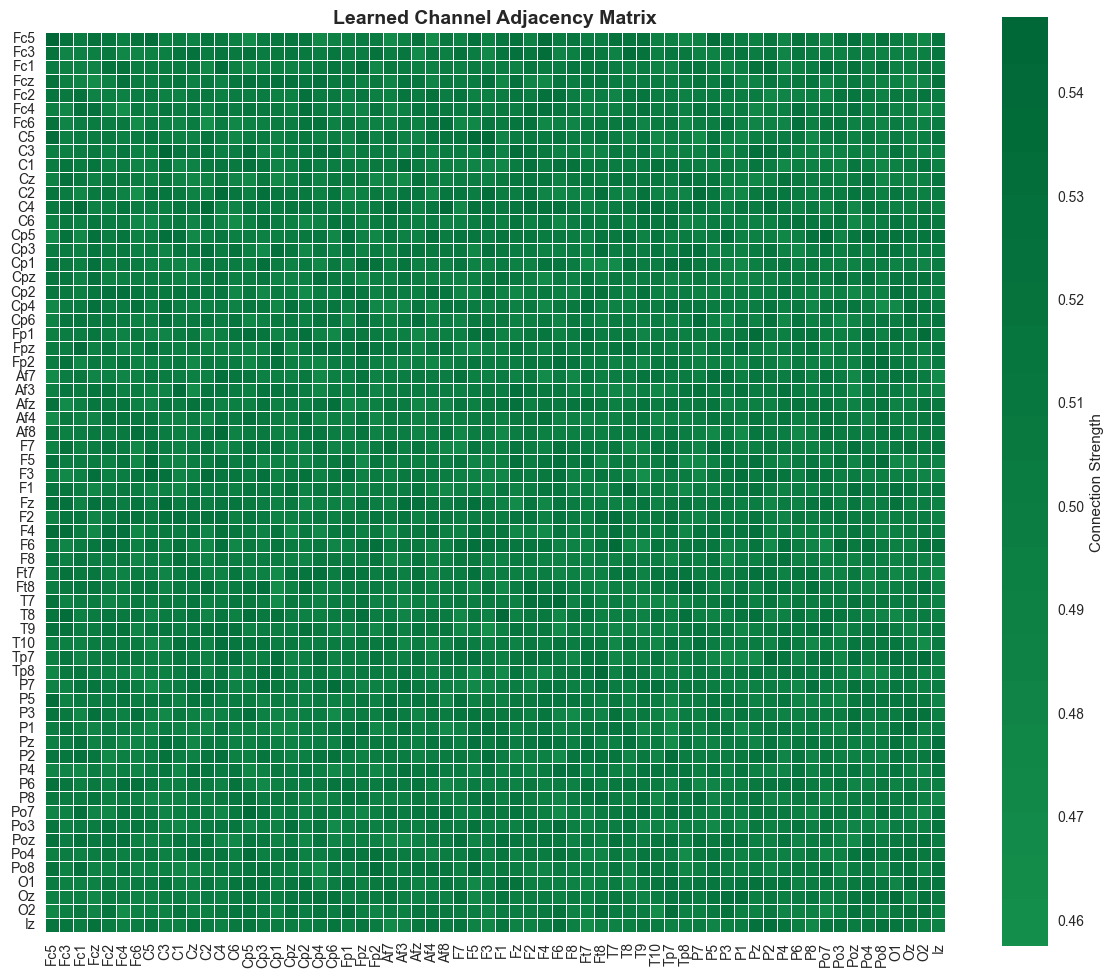


Top 10 Edges (Edge Selection):
Selected channels: ['Fc3', 'Fc1', 'C5', 'C2', 'C4', 'Cp5', 'Af8', 'F5', 'F3', 'F1', 'F4', 'F6', 'Ft8', 'T7', 'T8', 'Tp8', 'Po7']

Top 10 Channels (Aggregation Selection):
Selected channels: ['Fc5', 'Fc3', 'C4', 'Cp5', 'Cp3', 'Fpz', 'Fz', 'F2', 'F6', 'O1']


In [11]:
if len(all_results) > 0:
    # Pick best subject
    best_idx = results_df['all_channels_acc'].idxmax()
    best_result = all_results[best_idx]
    
    print(f"Visualizing adjacency matrix for best subject: {best_result['subject']}")
    print(f"Accuracy: {best_result['all_channels_acc']:.4f}")
    
    selector = ChannelSelector(best_result['adjacency_matrix'], best_result['channel_names'])
    
    fig = selector.visualize_adjacency(
        save_path=EXPERIMENT_CONFIG['output']['results_dir'] / f"adjacency_{best_result['subject']}.png"
    )
    plt.show()
    
    # Show top edges
    print("\nTop 10 Edges (Edge Selection):")
    selected_channels_es, _ = selector.edge_selection(10)
    print(f"Selected channels: {selected_channels_es}")
    
    print("\nTop 10 Channels (Aggregation Selection):")
    selected_channels_as, _ = selector.aggregation_selection(10)
    print(f"Selected channels: {selected_channels_as}")

## Export Results

In [12]:
if len(results_df) > 0:
    # Save subject results
    results_path = EXPERIMENT_CONFIG['output']['results_dir'] / 'subject_results.csv'
    results_df[['subject', 'num_trials', 'num_channels', 'all_channels_acc', 'all_channels_std']].to_csv(results_path, index=False)
    
    # Save channel selection results
    if len(channel_selection_df) > 0:
        channel_selection_path = EXPERIMENT_CONFIG['output']['results_dir'] / 'channel_selection_results.csv'
        channel_selection_df.to_csv(channel_selection_path, index=False)
    else:
        channel_selection_path = None
    
    # Save experiment config
    config_path = EXPERIMENT_CONFIG['output']['results_dir'] / 'experiment_config.json'
    with open(config_path, 'w') as f:
        json.dump(EXPERIMENT_CONFIG, f, indent=2, default=str)
    
    print("All results exported successfully!")
    print(f"  - Subject results: {results_path}")
    if channel_selection_path:
        print(f"  - Channel selection: {channel_selection_path}")
    print(f"  - Config: {config_path}")
else:
    print("No results to export.")

All results exported successfully!
  - Subject results: results\subject_results.csv
  - Channel selection: results\channel_selection_results.csv
  - Config: results\experiment_config.json
